# 中央値の信頼区間

* 黒木玄
* 2022-02-15
$
\newcommand\R{\Bbb{R}}
\newcommand\Beta{\operatorname{Beta}}
\newcommand\dist{\operatorname{dist}}
\newcommand\empirical{\operatorname{empirical}}
\newcommand\pval{\operatorname{pval}}
\newcommand\median{\operatorname{median}}
\newcommand\ci{\operatorname{ci}}
\newcommand\pdf{\operatorname{pdf}}
\newcommand\cdf{\operatorname{cdf}}
\newcommand\quantile{\operatorname{quantile}}
\newcommand\on{\operatorname}
$

In [1]:
using Distributions
using StatsPlots
default(titlefontsize=10, fmt=:png)
using Random
using StatsBase
using QuadGK
using StaticArrays

name(dist::UnivariateDistribution) = replace(string(dist), r"{[^{.]*}"=>"")

name (generic function with 1 method)

## 解説

### 順序統計量

この節については, [順序統計量 - Wikipedia](https://ja.wikipedia.org/wiki/%E9%A0%86%E5%BA%8F%E7%B5%B1%E8%A8%88%E9%87%8F)を参照.

$\R$ 上の確率分布 $\dist$ の累積分布函数を $\cdf(\dist,  x) = F(x)$ と書き, その「逆函数」を $\quantile(\dist, p) = F^{-1}(t)$ と書く.

分布 $\dist$ のサイズ $n$ の標本(独立同分布確率変数達)を $X=(X_1,\ldots,X_n)$ と書くとき, その中での下から $k$ 番目の値を $X_{(k)}$ と書き, 標本の第 $k$ __順序統計量__ と呼ぶ:

$$
X_{(1)} \le X_{(2)} \le \cdots \le X_{(n)}.
$$

このとき, $X_{(k)}$ が従う分布の累積分布函数 $F_{(k)}(x)$ は

$$
\begin{aligned}
F_{(k)}(x) & =
\cdf(\Beta(k, n-k+1), \cdf(\dist, x))
\\ & =
\frac{1}{B(k, n-k+1)}\int_0^{F(x)} t^{k-1}(1-t)^{n-k}\,dt.
\end{aligned}
$$

になる. ゆえにこれの「逆函数」は次のように表される:

$$
F^{-1}_{(k)}(t) = \quantile(\dist, \quantile(\Beta(k, n-k+1), t)).
$$

### 標本中央値の分布

未知の母集団分布 $\dist$ のサイズ $n$ の標本が得られたとし, その順序統計量を $X_{(k)}$ と書く.

このとき, 標本サイズが奇数で $n=2m-1$ のとき, $X_{(m)}$ を標本中央値と呼び, $n$ が偶数で $n=2m$ のとき $(X_{(m)} + X_{(m+1)})/2$ を標本中央値と呼ぶ. 標本 $X=(X_1,\ldots,X_n)$ の中央値を $\median(X)$ と書くことにする.

母集団分布 $\dist$ が連続的な分布ならば, 分布の中央値 $\median(\dist)$ が一意的に定まる. $\median(\dist)$ を母集団中央値と呼ぶことにする. 標本中央値 $\median(X)$ は母集団中央値の点推定量とみなされる.


標本サイズ $n$ が奇数の場合の標本中央値 $A=\median(X)$ の分布の累積分布函数は次のように書ける:

$$
\cdf_{\median}(\dist, n, a) =
\cdf\left(\Beta\left(\frac{n+1}{2}, \frac{n+1}{2}\right), \cdf(\dist, a)\right)
\quad\text{if $n$ is odd}.
$$

これのコンピュータ上での実装は易しい.

$n$ が偶数の場合には, 標本中央値 $\median(X)$ の累積分布函数は, $X_{(m)}$ と $X_{(m+1)}$ の同時分布(Dirichlet分布を使って書ける)の積分で書ける.　しかし, これをコンピュータ上で実装するのは少し面倒である.

そこで, $n$ が偶数の場合には上の公式で近似すれば良さそうに思うかもしれない. しかし, 驚くべきことに, $n$ が偶数の場合には1を足して奇数にしてからこの公式を適用するという処方箋を使う方が近似の精度がよくなる. ([中央値の分布とその近似](https://github.com/genkuroki/public/blob/main/0028/distribution%20of%20median%20and%20its%20approximations%20for%20even%20n%20case.ipynb)を参照せよ.) 以下ではその近似を使うことにする. すなわち, $n$ が奇数のとき $n'=n$ とし, $n$ が偶数のとき $n'=n+1$ とし, $\cdf_{\median'}(\dist, n, x)$ を以下のように定める:

$$
\cdf_{\median'}(\dist, n, a) =
\cdf\left(\Beta\left(\frac{n'+1}{2}, \frac{n'+1}{2}\right), \cdf(\dist, a)\right).
$$

$\cdf_{\median'}(\dist, n, a)$ の $a$ の函数としての「逆函数」を

$$
\quantile_{\median'}(\dist, n, t) =
\quantile\left(\dist, \quantile\left(\Beta\left(\frac{n'+1}{2}, \frac{n'+1}{2}\right), t\right)\right).
$$

と書くことにする.

__[中央値の分布とその近似](https://github.com/genkuroki/public/blob/main/0028/distribution%20of%20median%20and%20its%20approximations%20for%20even%20n%20case.ipynb)より:__ $n$ が偶数の場合には $n$ をそのまま使わずに $n+1$ を使った方が一様分布の標本中央値の真の分布をよく近似するようになる.

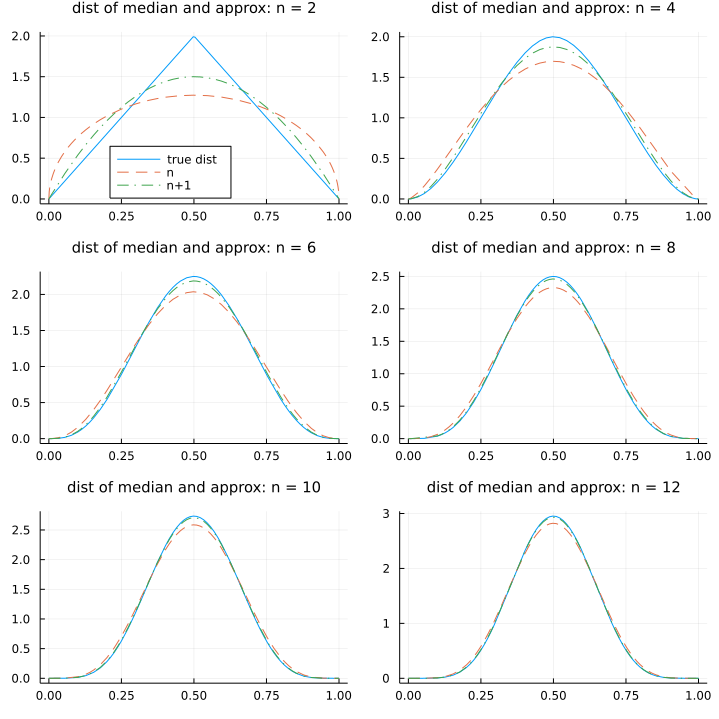

In [2]:
function pdf_median_true(n, z)
    0 < z < 1 || return 0.0
    m = n / 2
    p(x, y) = pdf(Dirichlet(SVector(m, 1, m)), SVector(x, y-x, 1-y))
    2quadgk(x -> p(x, 2z - x), 0, z)[1]
end

function plot_mediandists(n; kwargs...)
    plot(x -> pdf_median_true(n, x), 0, 1; label="true dist")
    plot!(x -> pdf(Beta((n+1)/2, (n+1)/2), x), 0, 1; ls=:dash, label="n")
    plot!(x -> pdf(Beta((n+2)/2, (n+2)/2), x), 0, 1; ls=:dashdot, label="n+1")
    title!("dist of median and approx: n = $n")
    plot!(; kwargs...)
end

PP = []
P = plot_mediandists(2; legend=:bottom)
push!(PP, P)
for n in 4:2:12
P = plot_mediandists(n; legend=false)
    push!(PP, P)
end
plot(PP...; size=(720, 720), layout=(3, 2))

### 標本から作られる経験分布

標本 $X=(X_1,\ldots,X_n)$ について, $X_i$ 達の値に重複がないとき, 値が $X_i$ になる確率が $1/n$ となる確率分布を $\empirical(X)$ と書き, 標本の __経験分布__ と呼ぶ. 重複がある場合には重複に応じた重み付けで確率を定めて経験分布を定義する.

### ブートストラップ法による中央値の仮説に関するＰ値函数の構成

「中央値は $a$ である」という仮説を考える.

分布 $\dist$ のサイズ $n$ の標本の中央値が分布の真の中央値 $\median(\dist)$ から仮説の値 $a$ 以上に離れる確率としてP値を次のように定義する(正確にはP値を片側確率の2倍として定義し, さらにP値を1以下になるように定義してあるので, 確率そのものではない):

$$
\pval_{\median'}(\dist, n, a) =
\min\left(\begin{array}{l}
 1 \\
 2\cdf_{\median'}(\dist, n, a) \\
 2(1 - \cdf_{\median'}(\dist, n, a)) \\
\end{array}\right).
$$

$n$ が奇数のとき $n'=n$ とし, $n$ が偶数のとき $n'=n+1$ とすると,

$$
\cdf_{\median'}(\dist, n, a) =
\cdf\left(\Beta\left(\frac{n'+1}{2}, \frac{n'+1}{2}\right), \cdf(\dist, a)\right).
$$

であることを使えば, 上のP値函数をコンピュータ上で容易に実装できる.

仮に分布 $\dist$ として母集団分布を使用できるならば, 「中央値は $a$ である」という仮説の疑わしさを評価するための正確な指標として上のP値を利用できる(P値が小さい場合には仮説は疑わしいと考える).  しかし, 母集団分布は実践的な状況では未知であるから使えない.

そこで, 標本 $X=(X_1,\ldots,X_n)$ の経験分布 $\empirical(X)$ を母集団分布の近似的代替物として用い, 標本 $X$ だけから計算できる上の仮説のP値を次のように定義する:

$$
\pval_{\median'}(X, a) = \pval_{\median'}(\empirical(X), n, a).
$$

標本サイズ $n$ が十分大きい場合には標本の経験分布 $\empirical(X)$ は母集団分布 $\dist$ をよく近似したものになるだろうが, $n$ が十分に大きくない場合には近似の誤差を気にする必要がある.

### ブートストラップ法による中央値の信頼区間の構成

有意水準 $0<\alpha<1$ と標本 $X=(X_1,\ldots,X_n)$ が与えられたとき, 信頼係数 $1-\alpha$ の中央値の信頼区間 $\ci_{\median',\alpha}(X)$ をP値 $\pval_{\median'}(X, a)$ が $\alpha$ 以上になる $a$ 全体の集合として定義できる(一般にP値函数が与えられたとき, 常に信頼区間をこのように定義できる).  その結果は次のようになる:

$$
\ci_{\median',\alpha}(X) = [L, R].
$$

ここで,

$$
\begin{aligned}
&
L = \quantile_{\median'}(\empirical(X), n, \alpha/2),
\\ &
U = \quantile_{\median'}(\empirical(X), n, 1-\alpha/2).
\end{aligned}
$$

$n$ が奇数のとき $n'=n$ とし, $n$ が偶数のとき $n'=n+1$ とすると,

$$
\quantile_{\median'}(\dist, n, t) =
\quantile\left(\dist, \quantile\left(\Beta\left(\frac{n'+1}{2}, \frac{n'+1}{2}\right), t\right)\right).
$$

であることを使えば, 上の信頼区間函数を容易に実装できる.

__注意:__ 以上では標本から作られる経験分布を未知の母集団分布の代替物として用いたが, もとの標本がデータが完全に残っていなくても, 例えばヒストグラムのデータが残っていれば, それをもとに標本から作られる経験分布の代替分布を作って $\empirical(X)$ の代わりに使えば, P値や信頼区間を計算することができる.

## 中央値の信頼区間はの計算はこれだけでよい

`n += iseven(n)` については[中央値の分布とその近似](https://github.com/genkuroki/public/blob/main/0028/distribution%20of%20median%20and%20its%20approximations%20for%20even%20n%20case.ipynb)を参照せよ.

(L, U) = (4.4007986547601945, 7.063926114907236)


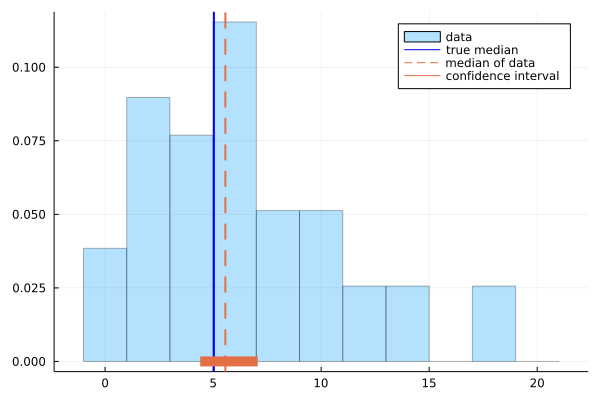

In [3]:
Random.seed!(3734649)

# テストサンプルの生成
dist = Gamma(2, 3)
n = 40
X = rand(dist, n)

# 標本Xの経験分布Xdistを作成
c = countmap(X)
u = collect(keys(c))
w = values(c) ./ n
Xdist = DiscreteNonParametric(u, w)

# Xdistとベータ分布のquantileで信頼区間を計算
n += iseven(n)
beta = Beta((n+1)/2, (n+1)/2)
L = quantile(Xdist, quantile(beta, 0.025))
U = quantile(Xdist, quantile(beta, 0.975))
@show L, U

# プロット
histogram(X; norm=true, alpha=0.3, bin=-1:2:21, label="data")
vline!([median(dist)]; label="true median", lw=2, c=:blue)
vline!([median(X)]; label="median of data", lw=2, c=2, ls=:dash)
plot!([L, U], zeros(2); label="confidence interval", lw=10, c=2)

(L, U) = (4.234117786308897, 7.148823320545663)


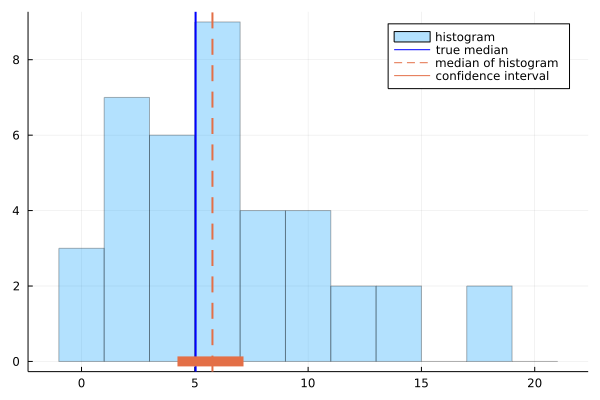

In [4]:
# ヒストグラムデータを作成
h = fit(Histogram, X, -1:2:21)

# ヒストグラムから得られる分布hdistを作成
e = h.edges[1]
w = h.weights
c = [Uniform(e[i], e[i+1]) for i in eachindex(e)[1:end-1]]
p = w / sum(w)
hdist = MixtureModel(c, p)

# hdistとベータ分布を用いて信頼区間を計算
n += iseven(n)
beta = Beta((n+1)/2, (n+1)/2)
L = quantile(hdist, quantile(beta, 0.025))
U = quantile(hdist, quantile(beta, 0.975))
@show L, U

# プロット
plot(h; norm=true, alpha=0.3, label="histogram")
vline!([median(dist)]; label="true median", lw=2, c=:blue)
vline!([median(hdist)]; label="median of histogram", lw=2, c=2, ls=:dash)
plot!([L, U], zeros(2); label="confidence interval", lw=10, c=2)

## もっと一般的な実装

### 順序統計量の分布のcdfとquantile

In [5]:
"""分布distのサイズnの標本の下からk番目の値の分布のcdf"""
cdf_ordstat(dist, n, k, x) = cdf(Beta(k, n-k+1), cdf(dist, x))

"""分布distの標本中央値の分布のcdf"""
cdf_median_old(dist, n, x) = cdf_ordstat(dist, n, (n+1)/2, x)
function cdf_median(dist, n, x)
    n += iseven(n)
    cdf_ordstat(dist, n, (n+1)/2, x)
end

"""分布distのサイズnの標本の下からk番目の値の分布のquantle(cdfの逆函数)"""
quantile_ordstat(dist, n, k, p) = quantile(dist, quantile(Beta(k, n-k+1), p))

"""分布distの標本中央値の分布のquantle(cdfの逆函数)"""
quantile_median_old(dist, n, p) = quantile_ordstat(dist, n, (n+1)/2, p)
function quantile_median(dist, n, p)
    n += iseven(n)
    quantile_ordstat(dist, n, (n+1)/2, p)
end

quantile_median (generic function with 1 method)

### 標本の経験分布やヒストグラムの分布

In [6]:
"""標本Xの経験分布(標本に重複がないことを仮定)"""
function empiricaldist(X)
    n = length(X)
    DiscreteNonParametric(X, fill(1/n, n))
end

"""標本Xの経験分布(標本に重複があってもよい)"""
function empiricaldist_allowrep(X) # very slow
    c = countmap(X)
    u = collect(keys(c))
    w = values(c) ./ length(X)
    DiscreteNonParametric(u, w) 
end

"""ヒストグラムの分布"""
function histogramdist(h::Histogram)
    e = h.edges[1]
    w = h.weights
    c = [Uniform(e[i], e[i+1]) for i in eachindex(e)[1:end-1]]
    p = w/sum(w)
    MixtureModel(c, p)
end

histogramdist

h = fit(Histogram, X, -4.25:0.5:4.25) = Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -4.25:0.5:4.25
weights: [0, 0, 1, 5, 4, 11, 27, 39, 38, 42, 18, 8, 6, 1, 0, 0, 0]
closed: left
isdensity: false
hdist = histogramdist(h) = MixtureModel{Uniform{Float64}}(K = 17)
components[1] (prior = 0.0000): Uniform{Float64}(a=-4.25, b=-3.75)
components[2] (prior = 0.0000): Uniform{Float64}(a=-3.75, b=-3.25)
components[3] (prior = 0.0050): Uniform{Float64}(a=-3.25, b=-2.75)
components[4] (prior = 0.0250): Uniform{Float64}(a=-2.75, b=-2.25)
components[5] (prior = 0.0200): Uniform{Float64}(a=-2.25, b=-1.75)
components[6] (prior = 0.0550): Uniform{Float64}(a=-1.75, b=-1.25)
components[7] (prior = 0.1350): Uniform{Float64}(a=-1.25, b=-0.75)
components[8] (prior = 0.1950): Uniform{Float64}(a=-0.75, b=-0.25)
The rest are omitted ...



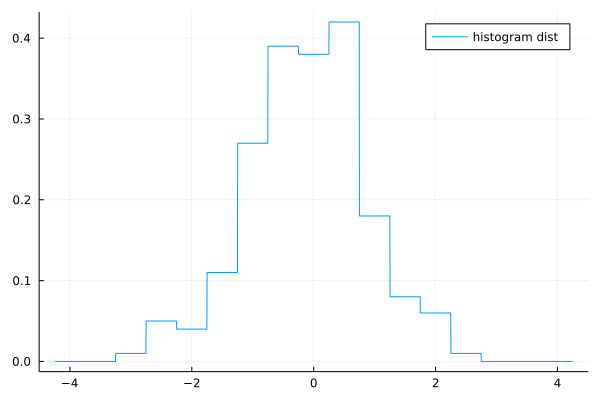

In [7]:
dist = Normal()
n = 200
X = rand(dist, n)
@show h = fit(Histogram, X, -4.25:0.5:4.25)
@show hdist = histogramdist(h)
plot(x -> pdf(hdist, x), extrema(hdist)...; label="histogram dist")

### P値函数と信頼区間

In [8]:
prevx(x::AbstractFloat) = prevfloat(x)
prevx(x::Integer) = x - 1

"""分布の順序統計量のP値"""
pval_ordstat(dist, n, k, a) = min(
    1,
    2cdf_ordstat(dist, n, k, a),
    2(1 - cdf_ordstat(dist, n, k, prevx(a)))
)

"""標本の順序統計量のP値"""
function pval_ordstat(X::AbstractVector, n, k, a; empiricaldist_func = empiricaldist_allowrep)
    dist = empiricaldist_func(X)
    pval_ordstat(dist, n, k, a)
end
pval_ordstat(X::AbstractVector, k, a; empiricaldist_func = empiricaldist_allowrep) =
    pval_ordstat(X, length(X), k, a; empiricaldist_func)

"""ヒストグラムの順序統計量のP値"""
function pval_ordstat(h::Histogram, n, k, a)
    dist = histogramdist(h)
    pval_ordstat(dist, n, k, a)
end

"""分布の標本中央値のP値"""
pval_median_old(dist, n, a) = pval_ordstat(dist, n, (n+1)/2, a)
function pval_median(dist, n, a)
    n += iseven(n)
    pval_ordstat(dist, n, (n+1)/2, a)
end

"""標本の分布の標本(bootstrap)の中央値のP値"""
pval_median_old(X::AbstractVector, n, a; empiricaldist_func = empiricaldist_allowrep) =
    pval_ordstat(X, n, (n+1)/2, a; empiricaldist_func)
function pval_median(X::AbstractVector, n, a; empiricaldist_func = empiricaldist_allowrep)
    n += iseven(n)
    pval_ordstat(X, n, (n+1)/2, a; empiricaldist_func)
end
pval_median(X::AbstractVector, a; empiricaldist_func = empiricaldist_allowrep) =
    pval_median(X, length(X), a; empiricaldist_func)

"""ヒストグラムの分布の標本の中央値のP値"""
pval_median_old(h::Histogram, n, a) = pval_ordstat(h, n, (n+1)/2, a)
function pval_median(h::Histogram, n, a)
    n += iseven(n)
    pval_ordstat(h, n, (n+1)/2, a)
end

pval_median (generic function with 4 methods)

In [9]:
"""分布の順序統計量の信頼区間"""
function ci_ordstat(dist, n, k; α = 0.05)
    L = quantile_ordstat(dist, n, k, α/2)
    U = quantile_ordstat(dist, n, k, 1 - α/2)
    L, U
end

"""標本の分布の順序統計量の信頼区間"""
ci_ordstat(X::AbstractVector, n, k; α = 0.05) = ci_ordstat(empiricaldist_allowrep(X), n, k; α)
ci_ordstat(X::AbstractVector, k; α = 0.05) = ci_ordstat(X, length(X), k; α)

"""ヒストグラムの分布の順序統計量の信頼区間"""
ci_ordstat(h::Histogram, n, k; α = 0.05) = ci_ordstat(histogramdist(h), n, k; α)

"""分布の中央値の信頼区間"""
ci_median_old(dist, n, k; α = 0.05) = ci_ordstat(dist, n, (n+1)/2; α)
function ci_median(dist, n, k; α = 0.05)
    n += iseven(n)
    ci_ordstat(dist, n, (n+1)/2; α)
end

"""標本の分布の中央値の信頼区間"""
ci_median_old(X::AbstractVector, n; α = 0.05) = ci_ordstat(X, n, (n+1)/2; α)
function ci_median(X::AbstractVector, n; α = 0.05)
    n += iseven(n)
    ci_ordstat(X, n, (n+1)/2; α)
end
ci_median(X::AbstractVector; α = 0.05) = ci_median(X, length(X); α)

"""ヒストグラムの分布の中央値の信頼区間"""
ci_median_old(h::Histogram, n; α = 0.05) = ci_ordstat(h, n, (n+1)/2; α)
function ci_median(h::Histogram, n; α = 0.05)
    n += iseven(n)
    ci_ordstat(h, n, (n+1)/2; α)
end

ci_median (generic function with 4 methods)

## 計算例

### RのDescToolsによる中央値の信頼区間の計算との比較

https://stats.stackexchange.com/questions/502977/confidence-interval-for-median-which-is-more-appropriate-bootstrap-or-binom-ex

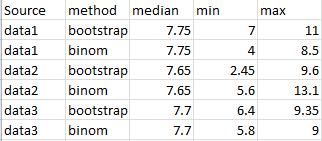

以下の計算結果はこの表のmethodがbinomの場合とぴったり一致している.

In [10]:
X = data1 = [8,    7,  8,  9.5,    1,  20, 8,  7.5,    3,  20.5,   2.5,    5.5,    15.5,   2,  4,  1,
    17,   2,  3.5,    8.5,    8.5,    2.5,    11, 4,  10.5,   7.5,    12, 5,  16.5,   8.5]
ci_median(X)

(4.0, 8.5)

In [11]:
X = data2 = [7.1,  32.0,   3.8,    1.6,    19.6,   6.0,    7.2,    14.9,   0,  2.0,    5.7,
          19.4, 13.1,   15.5,   11.3,   9.6,    13.9,   5.6,    12.6,   1.0,    1.9,
          8.1,  15.9,   0.8,    6.1,    8.1,    18.0,   4.6,    5.5,    15.6]
ci_median(X)

(5.6, 13.1)

In [12]:
X = data3 = [16.1, 10.4,   0.5,    12.2,   7.2,    1.7,    21.6,   6.3,    0.8,    3.2,    12.6,   20.0,   3.4, 7.3,   3.5,
          7.5,  15.8, 4.7, 8.3, 11.9,   1.6,    9.0, 8.6,   11.7,   8.1, 5.8, 3.3,  7.9,    7.0,    8.5]
ci_median(X)

(5.8, 9.0)

### P値函数と信頼区間

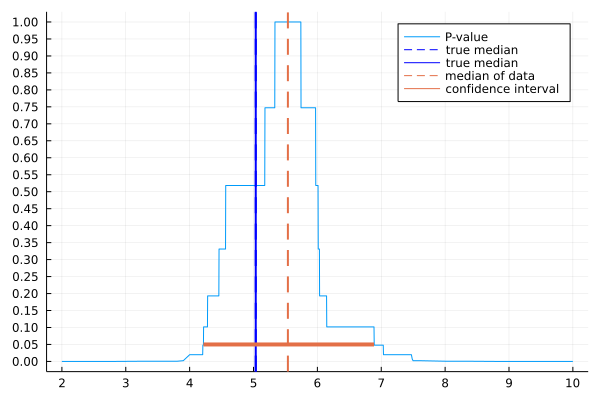

In [13]:
dist = Gamma(2, 3)
n = 40
X = rand(dist, n)
L, U = ci_median(X)

plot(x -> pval_median(X, x; empiricaldist_func = empiricaldist), 2, 10; label="P-value")
vline!([median(dist)]; label="true median", ls=:dash, lw=2, c=:blue)
vline!([median(dist)]; label="true median", lw=2, c=:blue)
vline!([median(X)]; label="median of data", lw=2, c=2, ls=:dash)
plot!([L, U], fill(0.05, 2); label="confidence interval", lw=4, c=2)
plot!(; xtick=0:20, ytick=0:0.05:1)

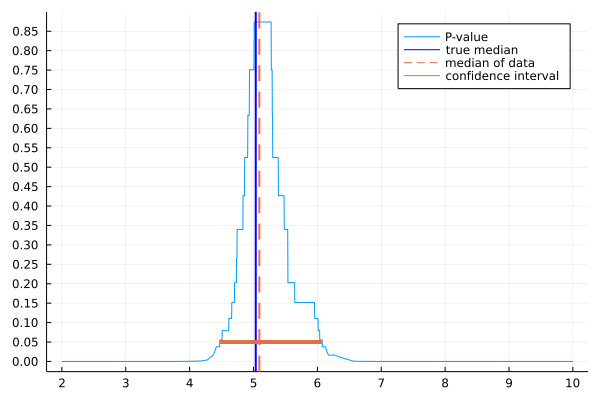

In [14]:
dist = Gamma(2, 3)
n = 160
X = rand(dist, n)
L, U = ci_median(X)

plot(x -> pval_median(X, x; empiricaldist_func = empiricaldist), 2, 10; label="P-value")
vline!([median(dist)]; label="true median", lw=2, c=:blue)
vline!([median(X)]; label="median of data", lw=2, c=2, ls=:dash)
plot!([L, U], fill(0.05, 2); label="confidence interval", lw=4, c=2)
plot!(; xtick=0:20, ytick=0:0.05:1)

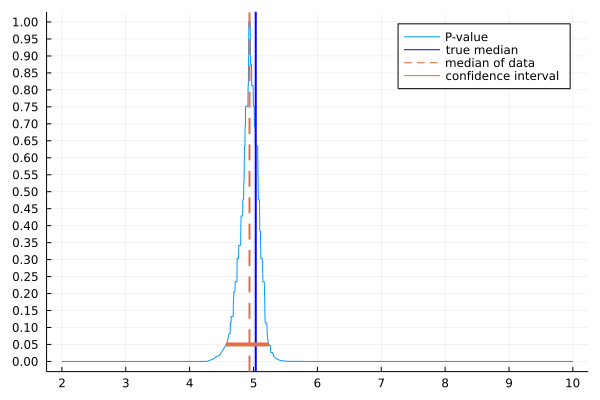

In [15]:
dist = Gamma(2, 3)
n = 640
X = rand(dist, n)
L, U = ci_median(X)

plot(x -> pval_median(X, x; empiricaldist_func = empiricaldist), 2, 10; label="P-value")
vline!([median(dist)]; label="true median", lw=2, c=:blue)
vline!([median(X)]; label="median of data", lw=2, c=2, ls=:dash)
plot!([L, U], fill(0.05, 2); label="confidence interval", lw=4, c=2)
plot!(; xtick=0:20, ytick=0:0.05:1)

### 第一種の過誤の確率

第一種の過誤の確率は母集団分布によらない.

In [16]:
function sim_mediantest(; n = 40, dists = [Normal(2, 3), Gamma(2, 3), Exponential(2), LogNormal()], L = 10^5)
    a = median.(dists)
    pval = Matrix{Float64}(undef, L, length(dists))
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        for (j, dist) in enumerate(dists)
            X = rand!(dist, tmp[Threads.threadid()])
            pval[i, j] = pval_median(X, a[j]; empiricaldist_func = empiricaldist)
        end
    end
    pval
end

function sim_mediantest_exact(; n = 40, dists = [Normal(2, 3), Gamma(2, 3), Exponential(2), LogNormal()], L = 10^5)
    pval = Matrix{Float64}(undef, L, length(dists))
    tmp = [Vector{Float64}(undef, n) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        for (j, dist) in enumerate(dists)
            X = rand!(dist, tmp[Threads.threadid()])
            pval[i, j] = pval_median(dist, n, median(X))
        end
    end
    pval
end

function plot_mediantest(;
        n = 40,
        dists = [Normal(2, 3), Gamma(2, 3), Exponential(2), LogNormal()],
        L = 10^5,
        sim_mediantest_func = sim_mediantest
    )
    pval = sim_mediantest_func(; n, dists, L)
    PP = []
    for (j, dist) in enumerate(dists)
        m = median(dist)
        s = std(dist)/√n
        P = plot(; legend=false)
        plot!(a -> ecdf(@view pval[:, j])(a), 0, 0.1; label="")
        plot!([0, 0.1], [0, 0.1]; label="", c=:black, ls=:dot)
        plot!(; xtick=0:0.01:1, ytick=0:0.01:1, xrotation=90)
        title!("$(name(dist)), n=$n")
        push!(PP, P)
    end
    plot(PP...; size=(640, 600), layout=(2, 2), titlefontsize=10, tickfontsize=6)
end

plot_mediantest (generic function with 1 method)

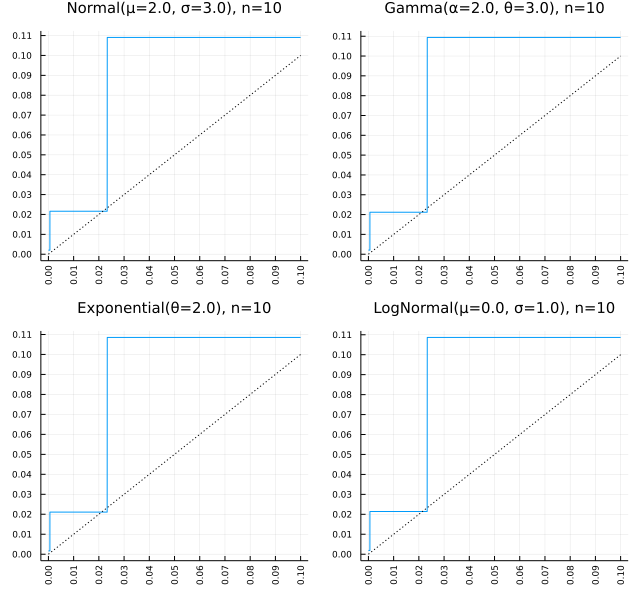

In [17]:
plot_mediantest(; n = 10)

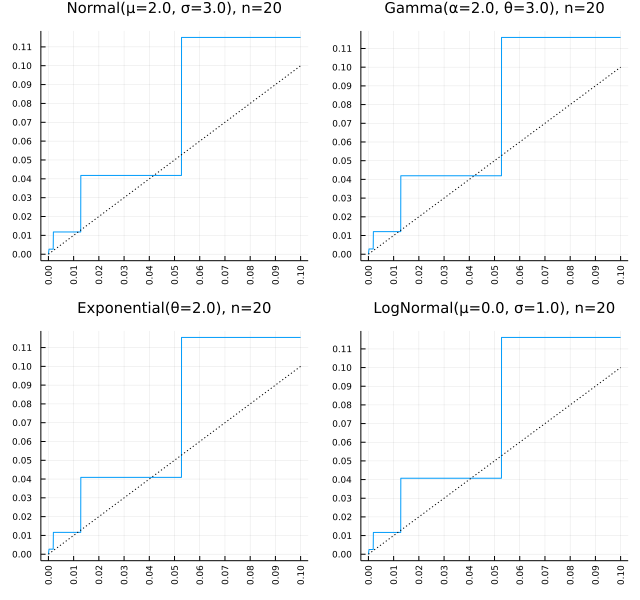

In [18]:
plot_mediantest(; n = 20)

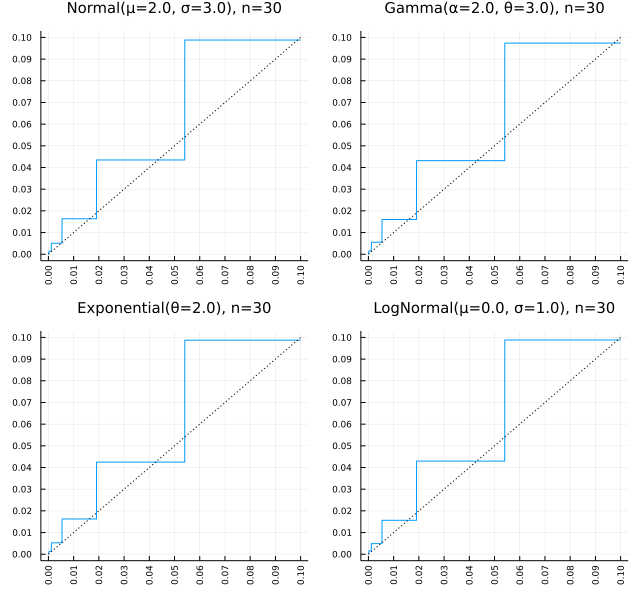

In [19]:
plot_mediantest(; n = 30)

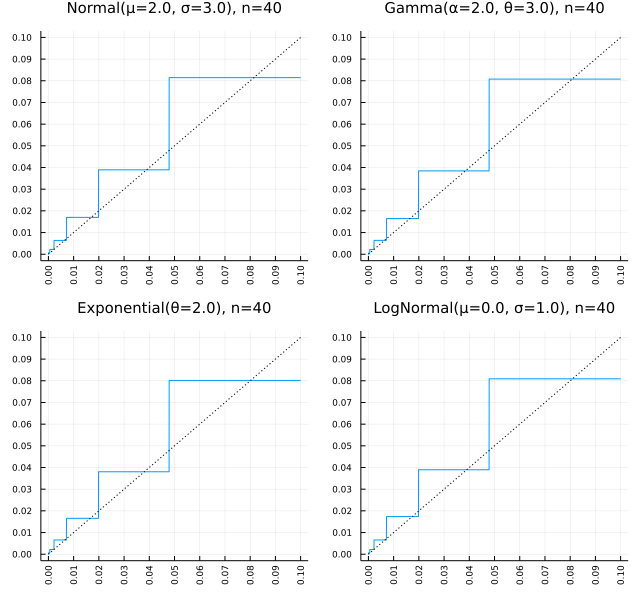

In [20]:
plot_mediantest(; n = 40)

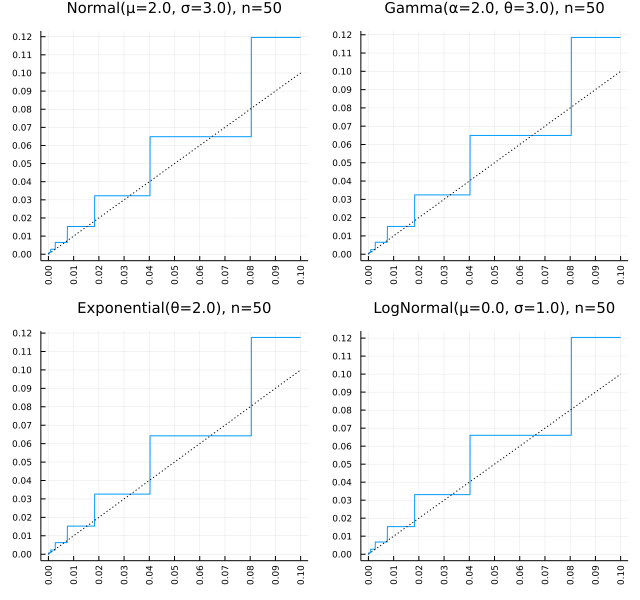

In [21]:
plot_mediantest(; n = 50)

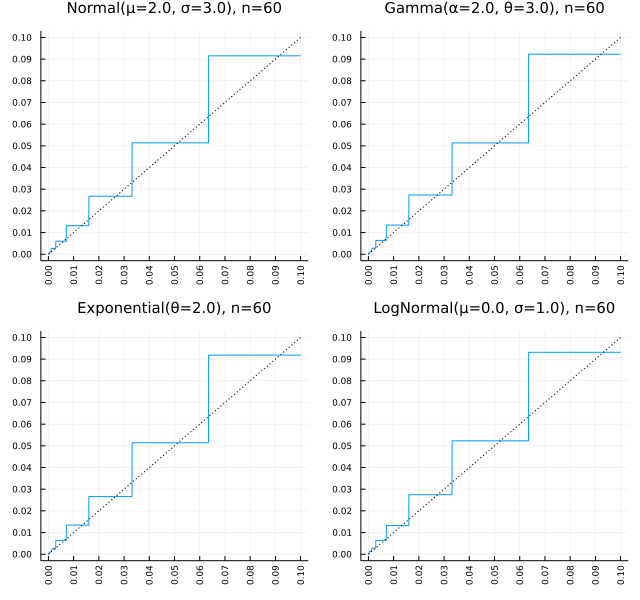

In [22]:
plot_mediantest(; n = 60)

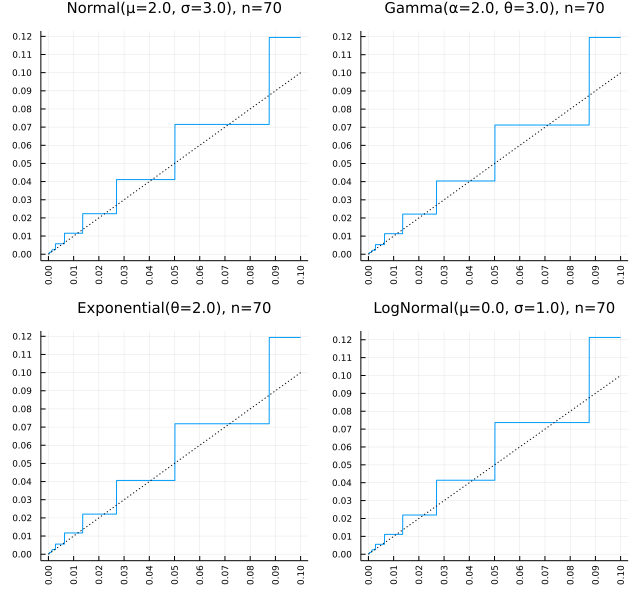

In [23]:
plot_mediantest(; n = 70)

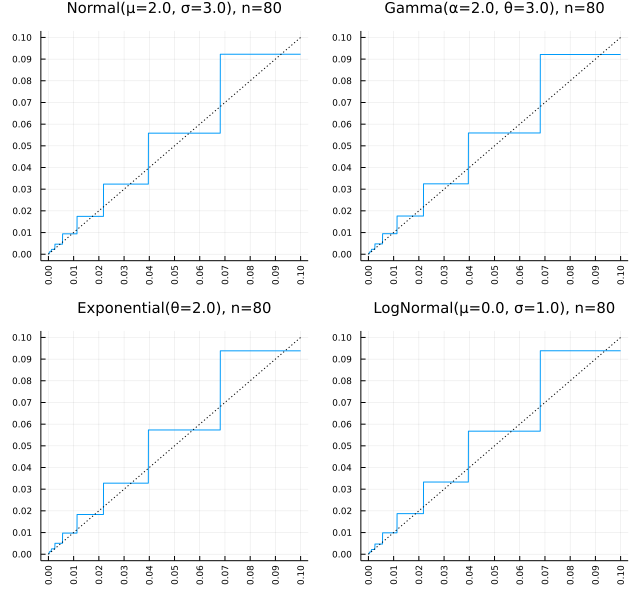

In [24]:
plot_mediantest(; n = 80)

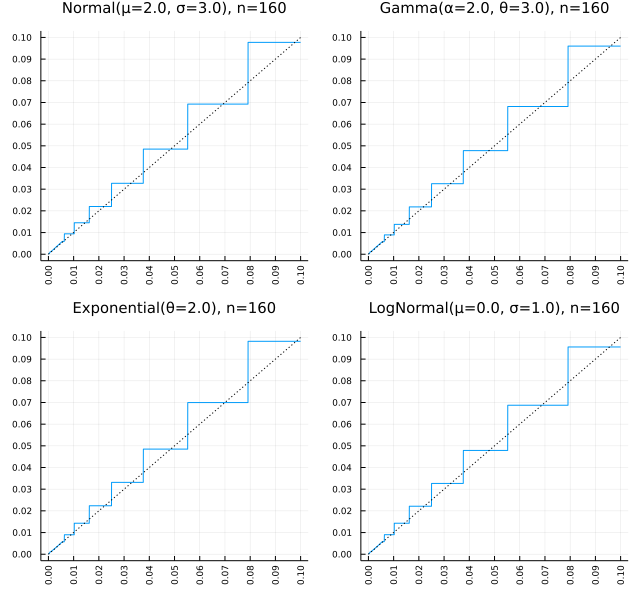

In [25]:
plot_mediantest(; n = 160)

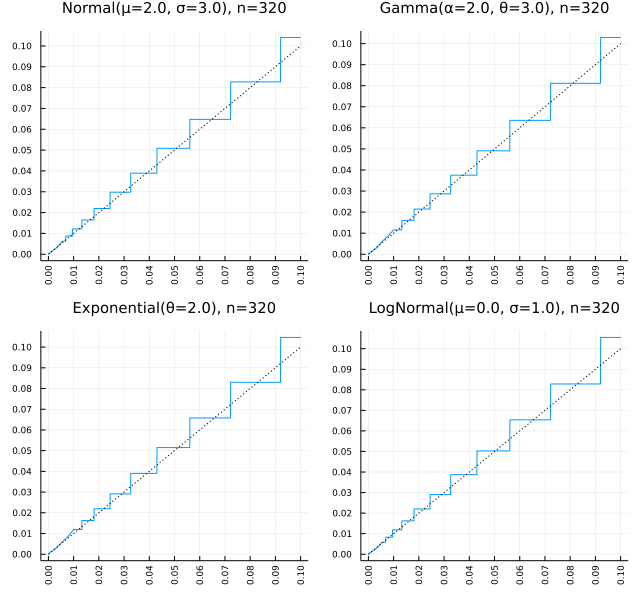

In [26]:
plot_mediantest(; n = 320)

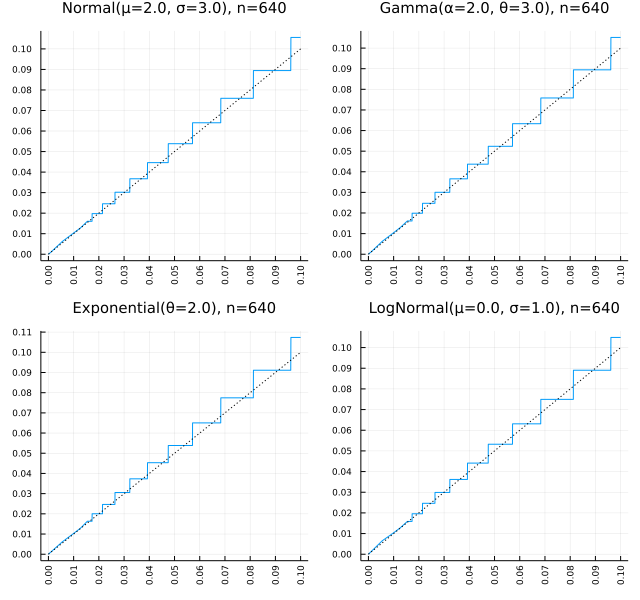

In [27]:
plot_mediantest(; n = 640)

以下は理論的にはほぼ完全に45度線に乗るはずの場合.

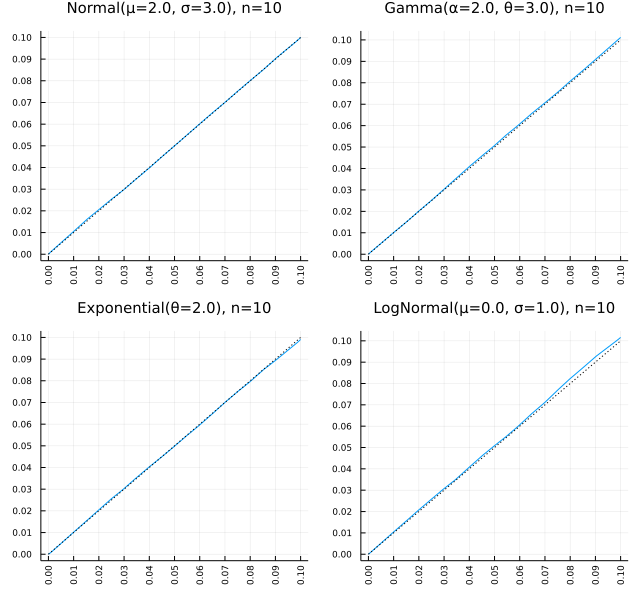

In [28]:
plot_mediantest(; n = 10, sim_mediantest_func = sim_mediantest_exact)

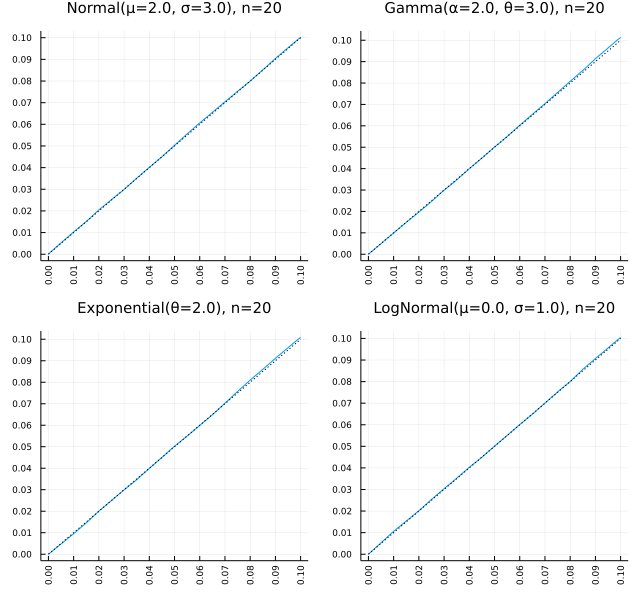

In [29]:
plot_mediantest(; n = 20, sim_mediantest_func = sim_mediantest_exact)

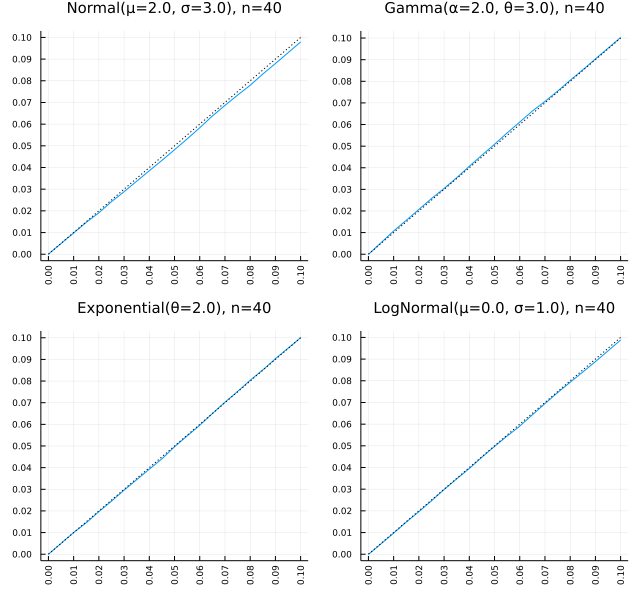

In [30]:
plot_mediantest(; n = 40, sim_mediantest_func = sim_mediantest_exact)

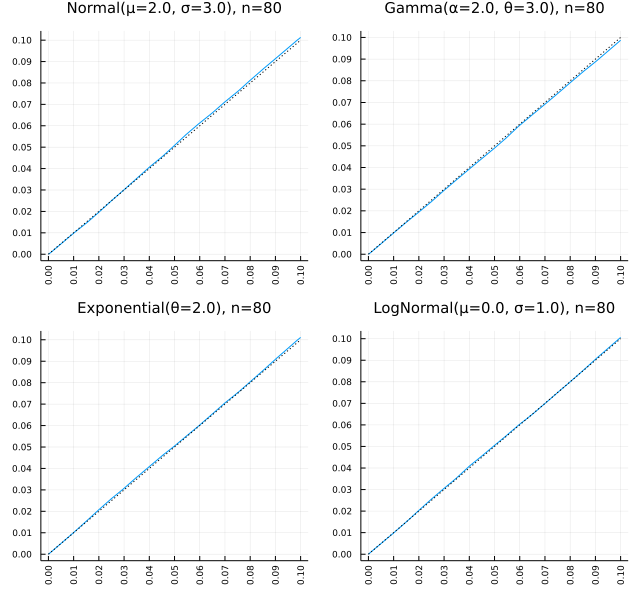

In [31]:
plot_mediantest(; n = 80, sim_mediantest_func = sim_mediantest_exact)

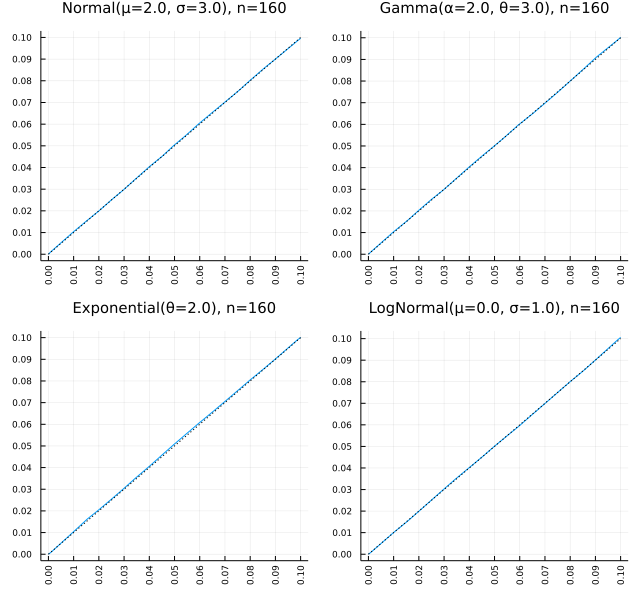

In [32]:
plot_mediantest(; n = 160, sim_mediantest_func = sim_mediantest_exact)